# Machine learning U(1) sharpening

# Imports, plus data loading

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from functools import reduce
from tqdm.notebook import tqdm
from itertools import product
data_loc = '../../../processed_data/'
plt.style.use('seaborn-whitegrid')

## Labelling data + preprocessing

In [2]:
Ls = [10, 12, 14, 16, 18]
ps = [0.05, 0.075, 0.1, 0.125, 0.15, 0.25, 0.35, 0.45, 0.5]

# read in the data
all_data = {}
for L in Ls:
    for p in ps:
        arr =  np.expand_dims(np.load(data_loc+f"{L},{p}.npy")[:10000, :, :, :2*L], 0) # drop last (fully measured) row
        #np.save(f"processed_data/{L},{p}.npy", arr)(-1)**(L==16 and p < 0.5 and p > 0.05)*
        all_data[(str(L), str(p))] = arr
        
# stack the data for different p
collated = {}
for key, value in sorted(all_data.items()):
    if key[0] in collated:
        collated[key[0]] = np.concatenate([collated[key[0]], value], axis=0)
    else:
        collated[key[0]] = value 

# get Q/Q+1 labels, shuffle both labels and images, store both, drop last (fully measured) row
datasets = {}
for key, value in collated.items():
    labels = np.repeat(np.expand_dims(np.concatenate([np.zeros((collated[key].shape[1], 1)), np.ones((collated[key].shape[1], 1))], axis=0), 0), len(ps), axis=0)
    datasets[key] = np.expand_dims(np.concatenate([collated[key][:, :, i, :, :] for i in [0, 1]], axis=1), -1).astype(float) # add dummy channels, float

    perm = np.arange(labels.shape[1])
    np.random.shuffle(perm)
    labels = labels[:, perm]
    datasets[key] = (datasets[key][:, perm], labels)
    
print("datasets")
for key, (x_train, y_train) in datasets.items():
    print(key, x_train.shape, y_train.shape)
print("collated")
for key, x in collated.items():
    print(key, x.shape)

datasets
10 (9, 20000, 10, 20, 1) (9, 20000, 1)
12 (9, 20000, 12, 24, 1) (9, 20000, 1)
14 (9, 20000, 14, 28, 1) (9, 20000, 1)
16 (9, 20000, 16, 32, 1) (9, 20000, 1)
18 (9, 20000, 18, 36, 1) (9, 20000, 1)
collated
10 (9, 10000, 2, 10, 20)
12 (9, 10000, 2, 12, 24)
14 (9, 10000, 2, 14, 28)
16 (9, 10000, 2, 16, 32)
18 (9, 10000, 2, 18, 36)


# Percolation

## Algorithm

In [3]:
from measurement_analysis.percolation import is_percolation, find_clusters_bond

## Analysis on sharp sites

A typical trajectory. We have a bond percolation problem on a tilted square lattice. 

/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_59825/2786336956.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[0].pcolormesh(ids, edgecolors='k', linewidth=2, cmap='jet')
/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_59825/2786336956.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[1].pcolormesh(1-abs_record, edgecolors='w', linewidth=2, cmap='bone_r')
/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_59825/2786336956.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[2].pcolormesh(record, edgecolors='w',cmap='bwr', vmin=-1, 

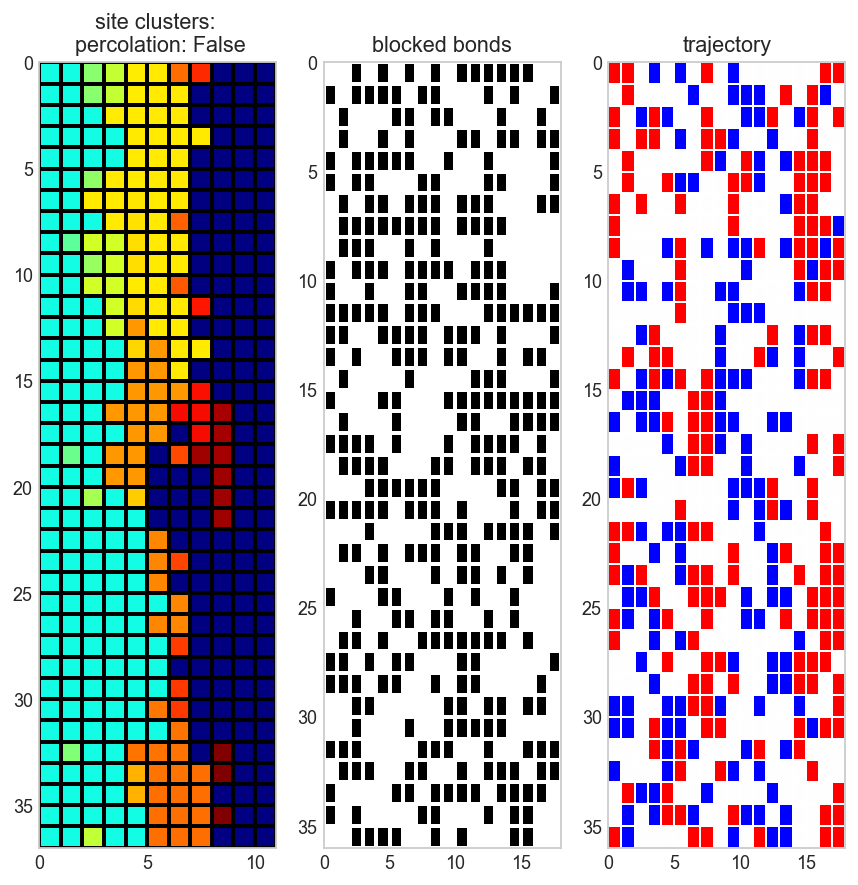

In [4]:
record = collated['18'][-2, 5, 0].T 
abs_record = np.abs(record)
clusters, ids = find_clusters_bond(abs_record)
percolation = is_percolation(ids)

fig, ax = plt.subplots(1, 3, dpi=130, figsize=(8, 8))
ax[0].set_title(f'site clusters: \n percolation: {percolation}')
ax[1].set_title('blocked bonds')
ax[2].set_title('trajectory')

ax[0].pcolormesh(ids, edgecolors='k', linewidth=2, cmap='jet')
ax[1].pcolormesh(1-abs_record, edgecolors='w', linewidth=2, cmap='bone_r')
ax[2].pcolormesh(record, edgecolors='w',cmap='bwr', vmin=-1, vmax=1)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis();

### Locating the percolation transition

In [5]:
all_perc_probs = []
for L in [str(L) for L in Ls]:
    perc_probs = []
    K = 2000
    for p_ind in range(0, 9):
        percolations = []
        for i, record in enumerate(collated[L][p_ind, :K, 0]):
            print(f"{L}:{ps[p_ind]}: {i}   \r", end='')
            record = record.T
            record = record[:min(record.shape), :min(record.shape)]
            abs_record = np.abs(record)
            clusters, ids = find_clusters_bond(abs_record)
            percolations.append(is_percolation(ids))
        perc_probs.append(np.mean(percolations))
    all_perc_probs.append(perc_probs)

KeyboardInterrupt: 

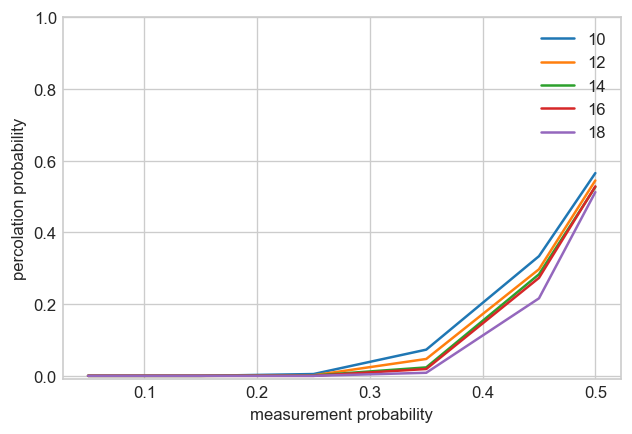

In [42]:
plt.figure(dpi=120)
for i, perc_probs in enumerate(all_perc_probs):
    plt.plot(ps, perc_probs, label=str(Ls[i]))
plt.legend()
plt.ylim([-1e-2, 1]);
plt.ylabel('percolation probability')
plt.xlabel('measurement probability');

Detecting site percolation. This problem isn't site percolation though - diagonal neighbours should be included too

## Analysis on sharp sites + unmeasured sharp sites
Fill out unsharp sites using information from sharp sites

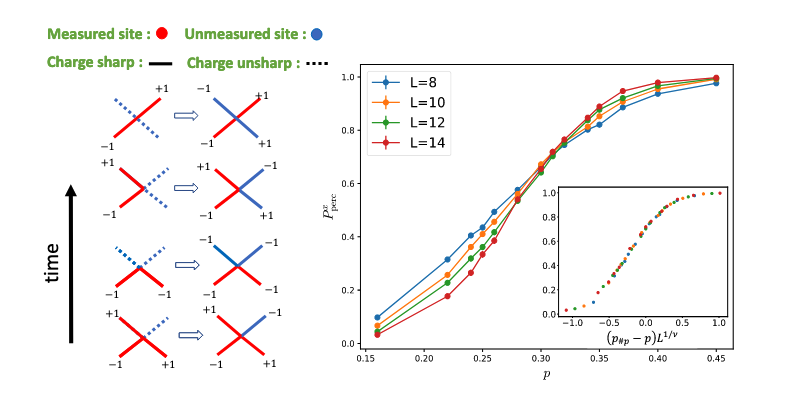

### Algorithm

In [4]:
integer = np.random.randint(0, 500)

In [9]:
from measurement_analysis.unmeasured_percolation import iterated_fill_out, fill_out
from measurement_analysis.graph import get_graph

### Analysis

/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_61175/2088505016.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[0].pcolormesh(ids, edgecolors='k', linewidth=2, cmap='jet')
/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_61175/2088505016.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[2].pcolormesh(1-filled_abs_record, edgecolors='w', linewidth=2, cmap='bone_r')
/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_61175/2088505016.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax[1].pcolormesh(1-filled_abs_record2, edgecolors='w',

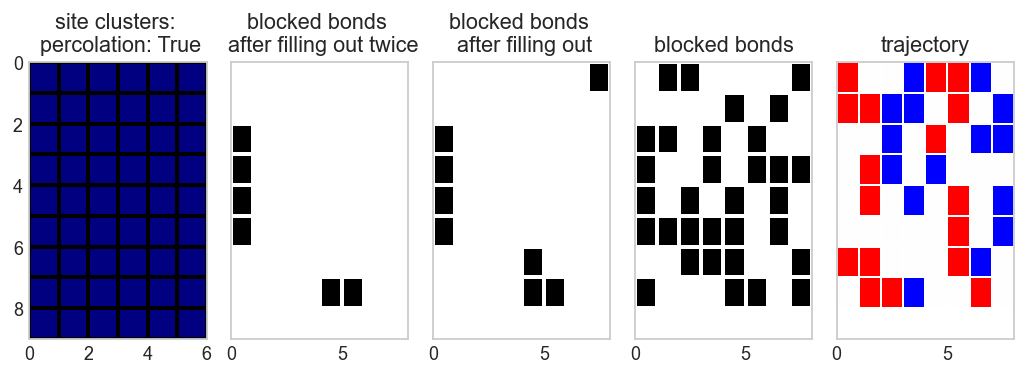

In [14]:
record = collated['18'][-1, np.random.randint(0, 50), 0][:min(record.shape), :min(record.shape)].T 

abs_record = np.abs((np.copy(record)))
filled_abs_record = np.abs(fill_out(np.copy(record)))
filled_abs_record2 = np.abs(fill_out(fill_out(np.copy(record))))

clusters, ids = find_clusters_bond(filled_abs_record2)
percolation = is_percolation(ids)

fig, ax = plt.subplots(1, 5, dpi=130, figsize=(8, 3), sharey=True)
ax[0].set_title(f'site clusters: \n percolation: {percolation}')
ax[1].set_title('blocked bonds \n after filling out twice')

ax[2].set_title('blocked bonds \n after filling out')
ax[3].set_title('blocked bonds')
ax[4].set_title('trajectory')

ax[0].pcolormesh(ids, edgecolors='k', linewidth=2, cmap='jet')
ax[2].pcolormesh(1-filled_abs_record, edgecolors='w', linewidth=2, cmap='bone_r')
ax[1].pcolormesh(1-filled_abs_record2, edgecolors='w', linewidth=2, cmap='bone_r')
ax[3].pcolormesh(1-abs_record, edgecolors='w', linewidth=2, cmap='bone_r')
ax[4].pcolormesh(record, edgecolors='w',cmap='bwr', vmin=-1, vmax=1)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()
ax[3].invert_yaxis();

fig.tight_layout()

### Locating the unmeasured sharp site percolation transition

In [15]:
all_perc_probs = []
for L in tqdm([str(L) for L in Ls]):
    perc_probs = []
    K = 1000
    for p_ind in tqdm(range(0, 9), leave=False):
        percolations = []
        for i, record in list(enumerate(collated[L][p_ind, :K, 0])):
            record = record[:min(record.shape), :min(record.shape)].T # make square, and transpose
            abs_record = np.abs(iterated_fill_out(np.copy(record))) # fill out the record using local rules, and get the absolute value
            clusters, ids = find_clusters_bond(abs_record) # find the clusters in the record
            percolations.append(is_percolation(ids)) # check if there is a percolating cluster
        perc_probs.append(np.mean(percolations)) # What fraction of the time do we get a percolating cluster for this p
    all_perc_probs.append(perc_probs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

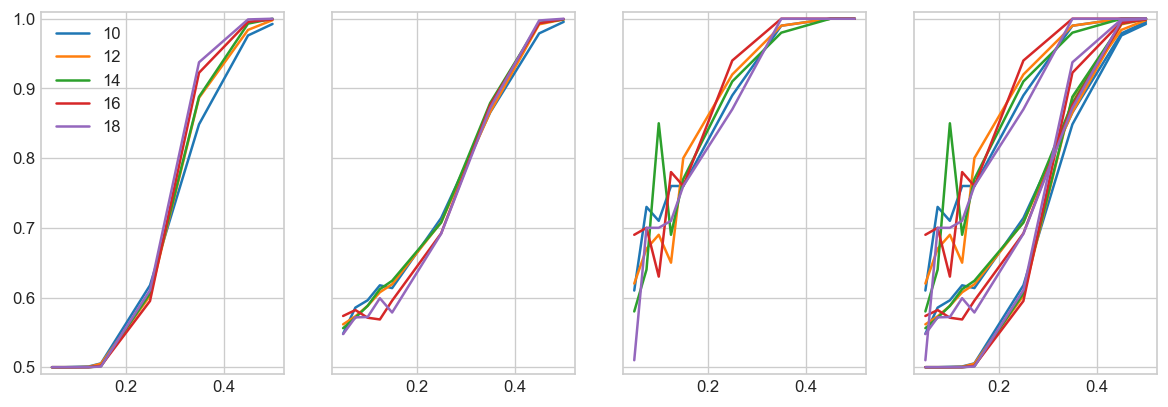

<Figure size 720x480 with 0 Axes>

In [2333]:
Ls = [10, 12, 14, 16, 18]

fig, ax = plt.subplots(1, 4, sharey=True, dpi=120, figsize=(12, 4))
plt.figure(dpi=120)
for i, perc_probs in enumerate(all_perc_probs):
    ax[0].plot(ps, 1/2*(1+np.array(perc_probs)), label=str(Ls[i]), color=f'C{i}')
    ax[3].plot(ps, 1/2*(1+np.array(perc_probs)), label=str(Ls[i]), color=f'C{i}')
    ax[1].plot(ps, np.array(all_accuracies)[i], label=Ls[i], color=f'C{i}')
    ax[3].plot(ps, np.array(all_accuracies)[i], label=Ls[i], color=f'C{i}')

    ax[2].plot(ps, np.array(list(acollated.values()))[i], label=list(acollated.keys())[i])
    ax[3].plot(ps, np.array(list(acollated.values()))[i], label=list(acollated.keys())[i])


ax[0].legend()
ax[0].set_ylim([0.5-1e-2, 1+1e-2]);
ax[0].legend();

In [2308]:
a = {(10, '0.05'): 0.61, (10, '0.075'): 0.73, (10, '0.1'): 0.71, (10, '0.125'): 0.76, (10, '0.15'): 0.76, (10, '0.25'): 0.89,(10, '0.35'): 0.99, (10, '0.45'): 1.0, (10, '0.5'): 1.0, (12, '0.05'): 0.62, (12, '0.075'): 0.67, (12, '0.1'): 0.69, (12,'0.125'): 0.65, (12, '0.15'): 0.8, (12, '0.25'): 0.92, (12, '0.35'): 0.99, (12, '0.45'): 1.0, (12, '0.5'): 1.0, (14, '0.05'): 0.58, (14, '0.075'): 0.64, (14, '0.1'): 0.85, (14, '0.125'): 0.69, (14, '0.15'): 0.77, (14, '0.25'): 0.91, (14, '0.35'): 0.98, (14, '0.45'): 1.0, (14, '0.5'): 1.0, (16, '0.05'): 0.69, (16, '0.075'): 0.7, (16, '0.1'): 0.63, (16, '0.125'): 0.78, (16, '0.15'): 0.76, (16, '0.25'): 0.94, (16, '0.35'): 1.0, (16, '0.45'): 1.0, (16, '0.5'): 1.0, (18, '0.05'): 0.51, (18, '0.075'): 0.7, (18, '0.1'): 0.7, (18, '0.125'): 0.71, (18, '0.15'): 0.76, (18, '0.25'): 0.87, (18, '0.35'): 1.0, (18, '0.45'): 1.0, (18, '0.5'): 1.0, (20, '0.05'): 0.66, (20, '0.075'): 0.66, (20, '0.1'): 0.6, (20, '0.125'): 0.75, (20, '0.15'): 0.78, (20, '0.25'): 0.92, (20, '0.35'): 0.99, (20, '0.45'): 1.0, (20, '0.5'): 1.0}

In [2301]:
import matplotlib.pyplot as plt
import numpy as np

In [2315]:
aps = set()
aLs = set()
acollated = {}
for key, val in sorted(a.items()):
    aps.add(float(key[1]))
    aLs.add(int(key[0]))
    if int(key[0]) in acollated:
        acollated[key[0]].append(val)
    else:
        acollated[key[0]] = [val]

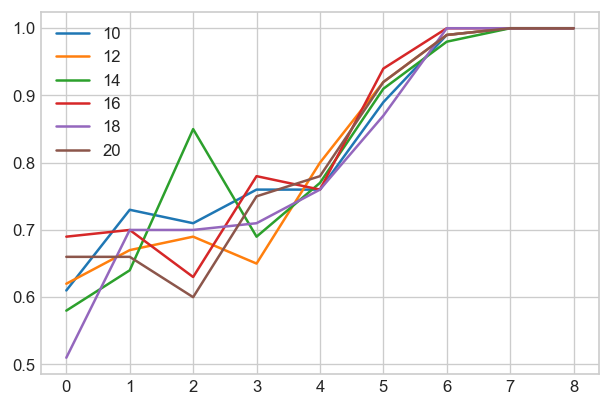

In [2316]:
plt.figure(dpi=120)
plt.plot(np.array(list(acollated.values())).T, label=list(acollated.keys()))
plt.legend();

In [25]:
np.array(list(collated.values()))

array([[0.61, 0.73, 0.71, 0.76, 0.76, 0.89, 0.99, 1.  , 1.  ],
       [0.62, 0.67, 0.69, 0.65, 0.8 , 0.92, 0.99, 1.  , 1.  ],
       [0.58, 0.64, 0.85, 0.69, 0.77, 0.91, 0.98, 1.  , 1.  ],
       [0.69, 0.7 , 0.63, 0.78, 0.76, 0.94, 1.  , 1.  , 1.  ],
       [0.51, 0.7 , 0.7 , 0.71, 0.76, 0.87, 1.  , 1.  , 1.  ],
       [0.66, 0.66, 0.6 , 0.75, 0.78, 0.92, 0.99, 1.  , 1.  ]])

## Determining the charge from a percolating trajectory
Any path through a percolating spanning cluster can be used to determine the total charge. 

### Algorithm

In [16]:
from measurement_analysis.graph import get_graph, complete_cycles, plot_global_lattice, graph_predict, iterated_fill_out

### Analysis

#### Plotting

In [6]:
k = -3
record = np.copy(collated['18'][k, np.random.randint(0, 500), 0]).T
record = np.pad(record, pad_width = ((0, 0), (1, 2)), constant_values = ((0, 0), (-1, -1)))

record2 = iterated_fill_out(np.copy(record))
record3, paths, charges = complete_cycles(record2)
record4 = iterated_fill_out(np.copy(record3))

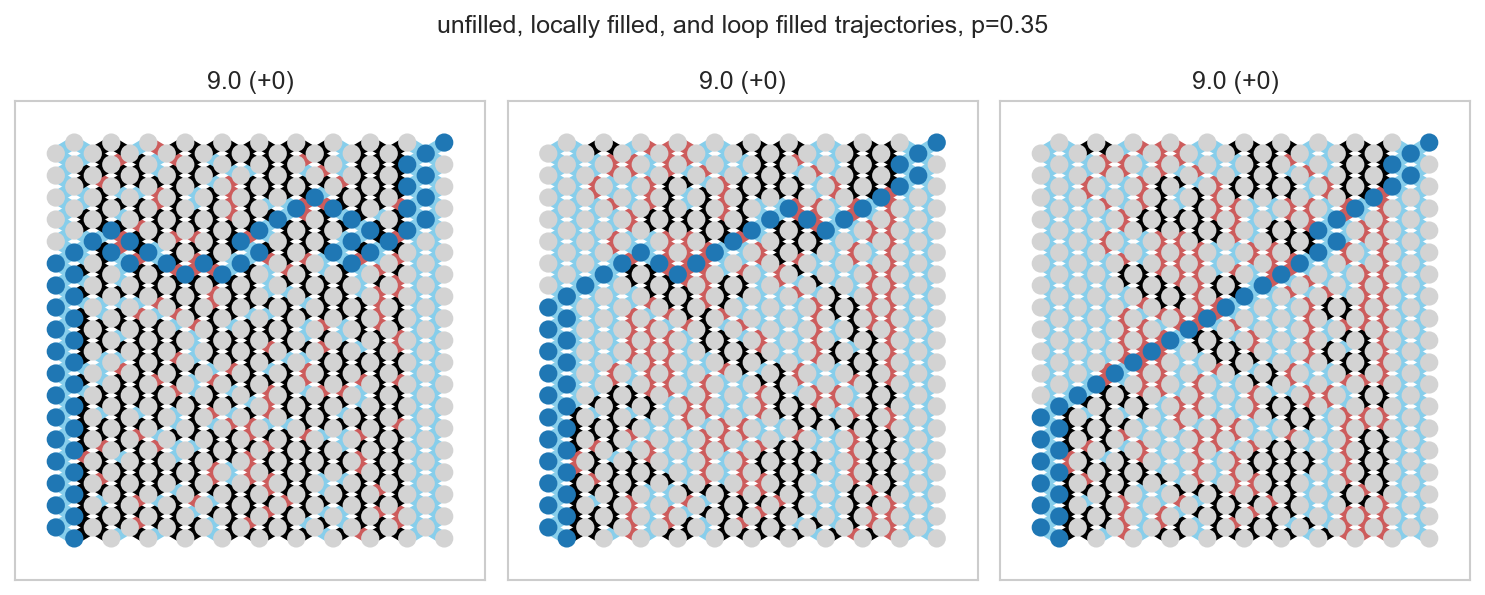

In [7]:
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 4))
plot_global_lattice(record, ax[0], 'path', paths=paths)
plot_global_lattice(record2, ax[1], 'path', paths=paths)
plot_global_lattice(record3, ax[2], 'path', paths=paths)

fig.suptitle(f"unfilled, locally filled, and loop filled trajectories, p={ps[k]}")
fig.tight_layout()

#### Global charge sharpening

In [17]:
N = 1000
preds = np.empty((len(Ls), 2, 9, N, 2))
for (L_ind, m, k, n) in tqdm(list(product(range(len(Ls)), range(2), range(9), range(N)))):
    record = np.copy(collated[str(Ls[L_ind])][k, n, m]).T
    preds[L_ind, m, k, n] = graph_predict(record)

  0%|          | 0/90000 [00:00<?, ?it/s]

KeyboardInterrupt: 

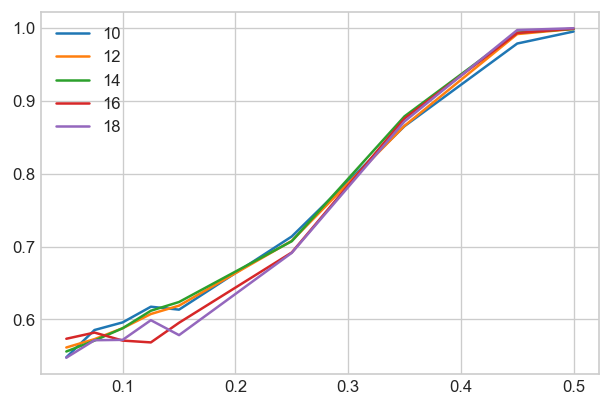

In [798]:
k = 1
all_accuracies = []
for L_ind in range(preds.shape[0]):
    accuracies = []
    for i in range(9):
        variances_q = preds[L_ind, 0, i, :, 0]+preds[L_ind, 0, i, :, 1]/2 # charge prediction is just the minimum + half the possible range. 
        variances_q_1 = preds[L_ind, 1, i, :, 0]+preds[L_ind, 1, i, :, 1]/2
        
        tp=np.mean(variances_q<=Ls[L_ind]/2+0.5)
        tn=np.mean(variances_q_1>Ls[L_ind]/2+0.5)
        fp=np.mean(variances_q>Ls[L_ind]/2+0.5)
        fn=np.mean(variances_q_1<=Ls[L_ind]/2+0.5)
        accuracies.append(acc:=(tp+tn)/(tp+tn+fn+fp))
    all_accuracies.append(accuracies)
plt.figure(dpi=120)
plt.plot(ps, np.array(all_accuracies).T, label=Ls)
plt.legend();

# Local charge sharpening

##### Algorithm

In [1074]:
def all_separations(rs, a, b):
    """
    All index pairs (i, j) with separations rs,  and a <= i < j < b
    """
    all_seps = []
    for r in rs:
        seps = []
        for i in range(a, b-r):
            seps.append([i, i+r])
        all_seps.append(seps)
    return all_seps
    
    
def plot_local_lattice(record, ax, which_colors='loops', paths=None):
    """
    plot a lattice with a shortest path from (0, topx-2) to (0, topx-8). 
    """
    G, edge_map = get_graph(record)

    pos=nx.get_node_attributes(G,'pos')

    
    def weight_fn(site1, site2, attrs):
        """
        returns the path we're most certain about. 1 for unmeasured links, 0 for measured links.
        """
        return attrs['weight']
    
    def high_charge_fn(site1, site2, attrs):
        """
        returns the path with the highest (definite) charge
        """
        rl = (1-2*(pos[site1][0]-pos[site2][0]))/2 # is the link right moving or left moving? (1 for left moving, 0 for right moving)
        return (0+rl if attrs['charge'] == 1 else 1) #(0 for right moving +1 measurements, 1 for everything else)
        
        
    fn = weight_fn
    top_right_node = list(sorted(G.nodes))[-1]

    topy, topx = top_right_node
    
    shortest_path = nx.shortest_path(G, (topy, topx-2), (topy, topx-8), weight=fn) # This path is the one we're most certain about. 

    broken_path = break_path(shortest_path, G, pos)[0]


    def in_which_path(node, paths):
        return np.argmax([node in path for path in paths])

    if which_colors =='uniform' or which_colors is None:
    #uniform
        node_colors = ["lightgray" for n in G.nodes()]
    elif which_colors=='path':
    # to color according to shortest path
        node_colors = [f"C{in_which_path(n, broken_path)}" if n in shortest_path else "lightgray" for n in G.nodes()]
    elif which_colors=='loops':
    # color filled in paths
        node_colors = [f"C{in_which_path(n, paths)}" if n in reduce(lambda x, y:x+y, paths, []) else "lightgray" for n in G.nodes()]
    else:
        which_colors = node_colors
        
    labels = nx.get_edge_attributes(G,'charge')

    edge_colors = ['skyblue' if G.get_edge_data(*edge)['charge']< 0 else 'indianred' if G.get_edge_data(*edge)['charge']> 0 else 'black' for edge in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=6, alpha=1);

    nx.draw_networkx_nodes(G,pos, node_color=node_colors, node_size=60, ax=ax, alpha=1);

    ax.grid(visible=None)
    ax.set_aspect(aspect='auto')
    charge, var = get_charge(shortest_path, G, pos)
    ax.set_title(f'{-charge} (+{var})');# {round(np.mean(np.abs(record)),3)}');

In [810]:
k = -4
record = np.copy(collated['18'][k, np.random.randint(0, 500), 1]).T
record = np.pad(record, pad_width = ((0, 0), (1, 2)), constant_values = ((0, 0), (-1, -1)))

record2 = iterated_fill_out(np.copy(record))
record3, paths, charges = complete_cycles(record2)
record4 = iterated_fill_out(np.copy(record3))

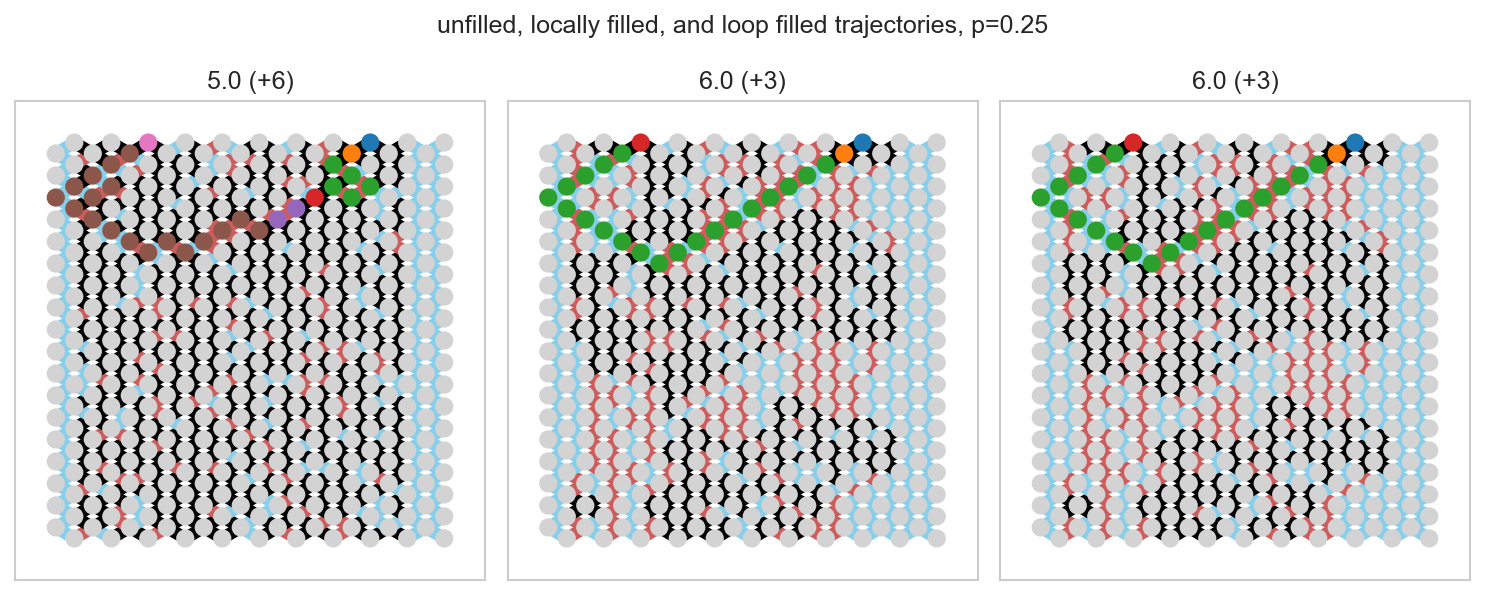

In [811]:
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 4))
plot_local_lattice(record, ax[0], 'path', paths=paths)
plot_local_lattice(record2, ax[1], 'path', paths=paths)
plot_local_lattice(record3, ax[2], 'path', paths=paths)

fig.suptitle(f"unfilled, locally filled, and loop filled trajectories, p={ps[k]}")
fig.tight_layout()

##### Analysis

In [607]:
def predict_local(record):
    """
    Get estimates for the minimum local charge, and local charge variance, as a function of the size of a local region
    """
    record = np.pad(record, pad_width = ((0, 0), (1, 2)), constant_values = ((0, 0), (-1, -1)))
    record = iterated_fill_out(np.copy(record))

    G, _ = get_graph(record)
    pos=nx.get_node_attributes(G,'pos')
    region = record.shape[1]//8, 3*record.shape[1]//8
    all_seps = all_separations(range(1, record.shape[1]//4), *region)
    all_min_charges =[]
    all_vars = []
    for seps in all_seps:
        min_charges = []
        vars = []
        for i, j in seps:
            shortest_path = nx.dijkstra_path(G, (0, i), (0, j))
            min_charge, var = get_charge(shortest_path, G, pos)
            min_charges.append(min_charge)
            vars.append(var)
        all_min_charges.append(min_charges)
        all_vars.append(vars)
    return np.array([[np.mean(x) for x in all_min_charges],[np.mean(x) for x in all_vars]])

N = 100
Ls = [18]
preds = np.empty((len(Ls), 2, 9, N, 2, 4))
for (L_ind, m, k, n) in tqdm(list(product(range(len(Ls)), range(2), range(9), range(N)))):
    record = np.copy(collated[str(Ls[L_ind])][k, n, m]).T
    x = predict_local(record)
    preds[L_ind, m, k, n, :, :] = predict_local(record)

  0%|          | 0/1800 [00:00<?, ?it/s]

In [619]:
res = np.squeeze(np.mean(preds, axis=3))[0]
res.shape

(9, 2, 4)

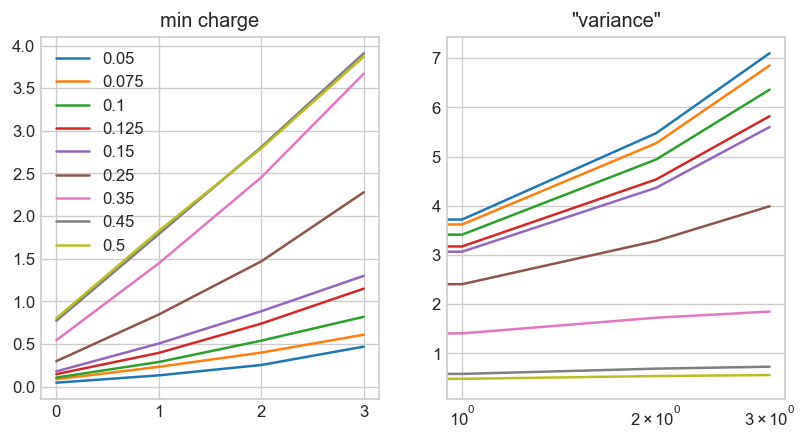

In [637]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(8, 4))
ax[0].plot(res[:, 0, :].T, label=ps);
ax[1].plot(res[:, 1, :].T, label=ps);
ax[0].set_title('min charge')
ax[1].set_title('"variance"');

ax[0].legend()
ax[1].set_xscale('log')

### Path filling

Scheme of work: 
- Any cycle basis for the graph represents a system of $O(L^2)$ [linear diophantine](https://en.wikipedia.org/wiki/Diophantine_equation#System_of_linear_Diophantine_equations) equations with values in $\mathbb{Z}_2$. 
- By counting the number of solutions with given values on the broken path, we can reconstruct the distribution on that path (at least whatever part of it we can access via the measurements)


In [835]:
k = -3
record = np.copy(collated['18'][k, np.random.randint(0, 500), 0]).T
record = np.pad(record, pad_width = ((0, 0), (1, 2)), constant_values = ((0, 0), (-1, -1)))

record2 = iterated_fill_out(np.copy(record))
record3, paths, charges = complete_cycles(record2)
record4 = iterated_fill_out(np.copy(record3))

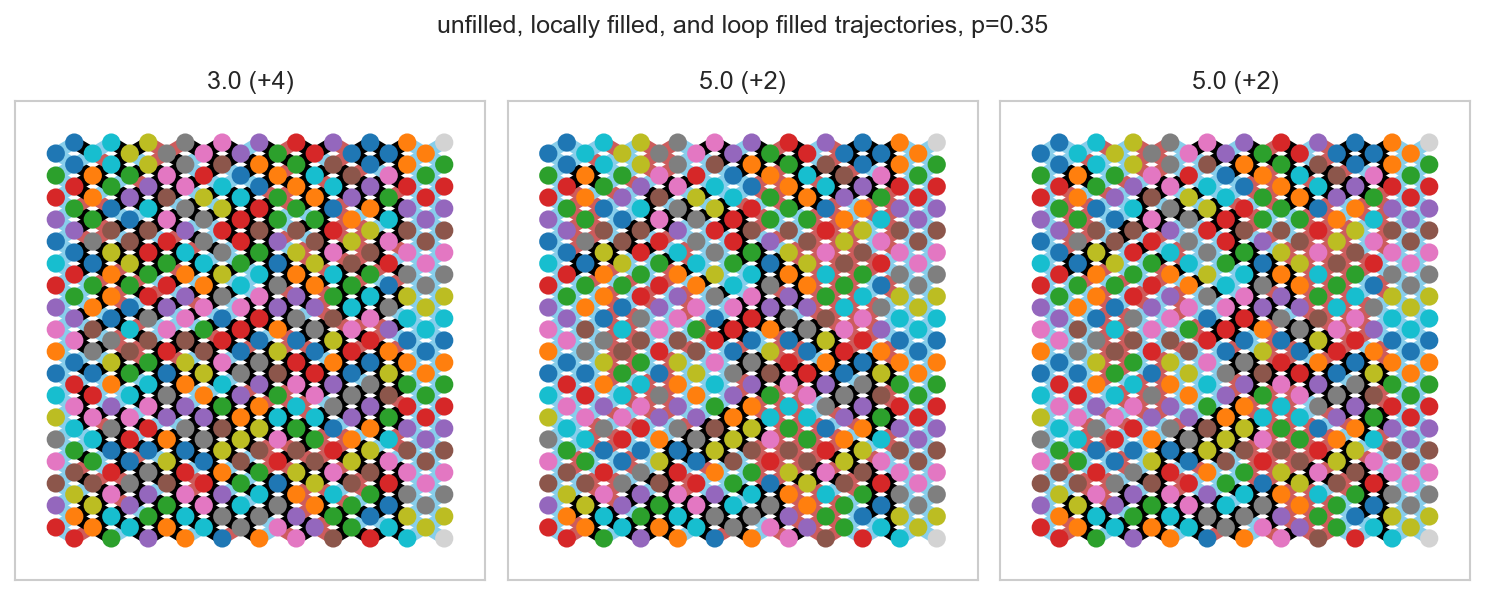

In [836]:
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 4))
plot_cycle_basis(record, ax[0], 'cycles', paths=paths)
plot_cycle_basis(record2, ax[1], 'cycles', paths=paths)
plot_cycle_basis(record3, ax[2], 'cycles', paths=paths)

fig.suptitle(f"unfilled, locally filled, and loop filled trajectories, p={ps[k]}")
fig.tight_layout()

In [2160]:
def plot_cycle_basis(record, ax, which_colors='loops', paths=None):
    """
    plot a lattice with a shortest path from (0, topx-2) to (0, topx-8). 
    """
    G, edge_map = get_graph(record)

    pos=nx.get_node_attributes(G,'pos')

    
    def weight_fn(site1, site2, attrs):
        """
        returns the path we're most certain about. 1 for unmeasured links, 0 for measured links.
        """
        return attrs['weight']
    
    def high_charge_fn(site1, site2, attrs):
        """
        returns the path with the highest (definite) charge
        """
        rl = (1-2*(pos[site1][0]-pos[site2][0]))/2 # is the link right moving or left moving? (1 for left moving, 0 for right moving)
        return (0+rl if attrs['charge'] == 1 else 1) #(0 for right moving +1 measurements, 1 for everything else)
        
        
    fn = weight_fn
    top_right_node = list(sorted(G.nodes))[-1]

    topy, topx = top_right_node
    
    shortest_path = nx.shortest_path(G, (topy, topx-2), (topy, topx-8), weight=fn) # This path is the one we're most certain about. 

    broken_path = break_path(shortest_path, G, pos)[0]


    def in_which_path(node, paths):
        return np.argmax([node in path for path in paths])

    if which_colors =='uniform' or which_colors is None:
    #uniform
        node_colors = ["lightgray" for n in G.nodes()]
    elif which_colors=='path':
    # to color according to shortest path
        node_colors = [f"C{in_which_path(n, broken_path)}" if n in shortest_path else "lightgray" for n in G.nodes()]
    elif which_colors=='loops':
    # color filled in paths
        node_colors = [f"C{in_which_path(n, paths)}" if n in reduce(lambda x, y:x+y, paths, []) else "lightgray" for n in G.nodes()]
    else:
        which_colors = node_colors
        
    labels = nx.get_edge_attributes(G,'charge')

    edge_colors = ['skyblue' if G.get_edge_data(*edge)['charge']< 0 else 'indianred' if G.get_edge_data(*edge)['charge']> 0 else 'black' for edge in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=6, alpha=1);

    nx.draw_networkx_nodes(G,pos, node_color=node_colors, node_size=60, ax=ax, alpha=1);

    ax.grid(visible=None)
    ax.set_aspect(aspect='auto')
    charge, var = get_charge(shortest_path, G, pos)
    ax.set_title(f'{-charge} (+{var})');# {round(np.mean(np.abs(record)),3)}');


def get_constraint(path, G, pos, verbose=False):
    """
    Get the constraint on the charges in a path. 
    """
    unknowns = []
    pathsum = 0
    for i in range(len(path)-1):
        data = G.get_edge_data(path[i],path[i+1])
        charge = (1+data['charge'])/2
        sign = -2*(pos[path[i]][0]-pos[path[i+1]][0])
        if charge not in [0., 1.]:
            unknowns+=[(sign, (path[i], path[i+1]))]
            continue
        if verbose:
            print(sign, pos[path[i]], pos[path[i+1]])
        pathsum += sign*charge
    if len(unknowns)==0:
        return None
    return pathsum, tuple(unknowns)

def get_short_cycles(record):
    G, edge_map = get_graph(record)

    pos=nx.get_node_attributes(G,'pos')

    top_right_node = list(sorted(G.nodes))[-1]

    topy, topx = top_right_node
    return [[(x+1, y), (x+2, y), (x+1, y+1), (x, y), (x+1, y)] if not x % 2 else [(x+1, y), (x+2, y+1), (x+1, y+1), (x, y+1), (x+1, y)] for x, y in product(range(topy-1), range(topx))]

def get_cycle_constraints(record, short=True):
    """
    Get the constraints for a cycle basis on this record
    """
    G, edge_map = get_graph(record)

    pos=nx.get_node_attributes(G,'pos')

    top_right_node = list(sorted(G.nodes))[-1]

    topy, topx = top_right_node
    if short:
        cycles = get_short_cycles(record)
    else:
        cycles = nx.cycle_basis(G)
        for i in range(len(cycles)):
            cycles[i].append(cycles[i][0])
        
    constraints = set()
    for cycle in cycles:
        constraint = get_constraint(cycle, G, pos)
        if constraint is not None:
            constraints.add(constraint)
            
    return constraints        
    
def get_paths(constraints):
    return [list(set(reduce(lambda x, y: x+y, X))) for X in [[y[1] for y in x[1]] for x in constraints]]    

def get_variables(constraints):
    variables = list(set(reduce(lambda x, y: x+y, [[frozenset(y[1]) for y in x[1]] for x in constraints])))
    return variables
    
def get_constraint_matrix_vector(constraints):
    """
    Get the matrix and vector corresponding to the linear constraints: Ax = b
    """
    variables = get_variables(constraints)
    
    b = np.array([x[0] for x in constraints])
    variables = list(variables)
    A = np.zeros((len(constraints), len(variables)))
    for i, constraint in enumerate(constraints):
        for weight, edge in constraint[1]:
            j = variables.index(frozenset(edge))
            A[i, j] = weight
    return A, b

def graph_from_paths(paths, graph):
    """
    build an nx graph from a list of paths in the graph. 
    """
    G = nx.Graph()
    for path in paths:
        G.add_nodes_from([(x, graph.nodes[x]) for x in path])
        for i in range(1, len(path)-1):
            G.add_edge(path[i-1], path[i])
            G.add_edge(path[i], path[i+1])
    return G

In [2153]:
def iterated_cycle_fill(record):
    while True:
        record2 = iterated_fill_out(np.copy(record))
        record2, paths, charges = complete_cycles(record2)
        if np.allclose(record, record2):
            break
        else:
            record = record2
    return record

In [2282]:
k = -3
print(ps[k])
record = np.copy(collated['18'][k, np.random.randint(0, 500), 0]).T
record = np.pad(record, pad_width = ((0, 0), (1, 2)), constant_values = ((0, 0), (-1, -1)))

record = iterated_cycle_fill(np.copy(record))
constraints = get_cycle_constraints(record)
constraints = sorted(constraints, key=lambda x: len(x[1])) # sort constraints in order of decreasing sparsity

print(len(get_variables(constraints)), len(constraints))

0.35
190 142


##### Plot constraints
nodes are unsharp sites, edges mean 'appears in constraint with'

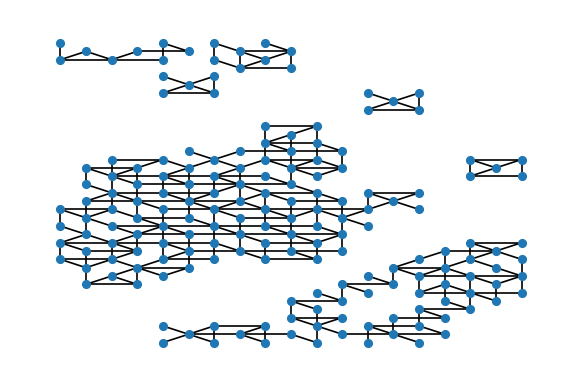

In [2283]:
G = graph_from_paths(get_paths(constraints), get_graph(record)[0])
fig, ax = plt.subplots(1, 1, dpi=120)
nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=20, ax=ax)

In [2107]:
N = 10
all_n_vars = []
all_n_consts = []
for k in range(len(ps)):
    n_consts = []
    n_vars = []
    for i in range(N):
        print(f'{k}, {i} \r', end='')
        record = np.copy(collated['18'][k, i, 0]).T
        record = iterated_fill_out(record)
        #record, paths, charges = complete_cycles(record)
        constraints = get_cycle_constraints(record)
        constraints = sorted(constraints, key=lambda x: len(x[1])) # sort constraints in order of decreasing sparsity
        n_consts.append(len(constraints))
        n_vars.append(len(get_variables(constraints)))
    all_n_vars.append(n_vars)
    all_n_consts.append(n_consts)

#### Number of constraints vs. number of variables

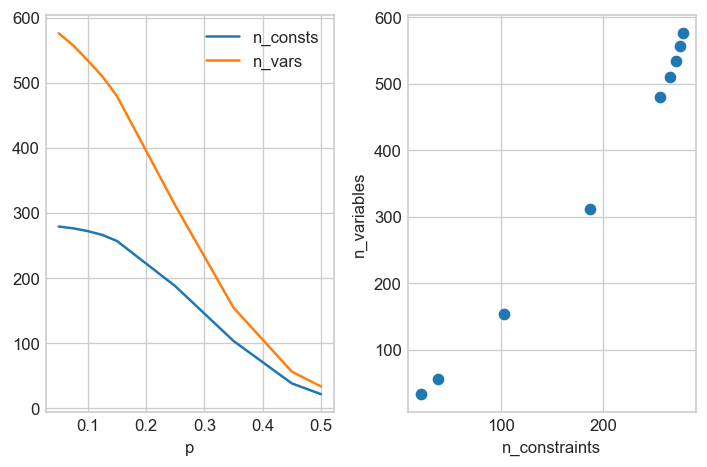

In [2289]:
fig, ax = plt.subplots(1, 2, dpi=120)
ax[0].plot(ps, [np.mean(x) for x in all_n_consts], label='n_consts')
ax[0].plot(ps, [np.mean(x) for x in all_n_vars], label='n_vars')
ax[1].scatter([np.mean(x) for x in all_n_consts], [np.mean(x) for x in all_n_vars])
ax[1].set_ylabel('n_variables')
ax[1].set_xlabel('n_constraints')
ax[0].set_xlabel('p')
ax[0].legend()
fig.tight_layout()

### Linear constraints

(142, 190) (142,)


/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_68202/343186152.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


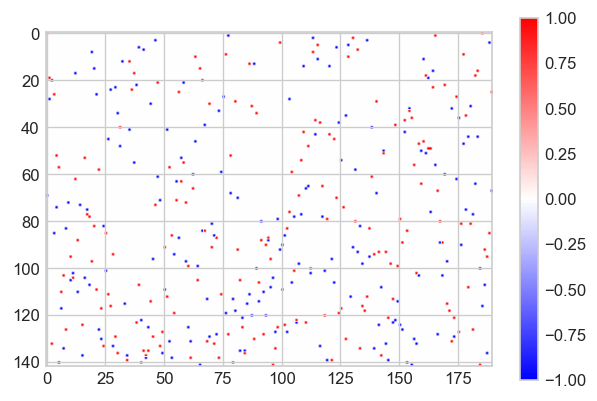

In [2290]:
A, b = get_constraint_matrix_vector(constraints)
print(A.shape, b.shape)
plt.figure(dpi=120)
plt.imshow(A, cmap='bwr')
plt.colorbar();

In [2293]:
print(np.count_nonzero(A, axis=1))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


### Basis for the solution space

/var/folders/jw/h71hy83j4gz_tp1pwg21sxb80000gn/T/ipykernel_68202/815699511.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


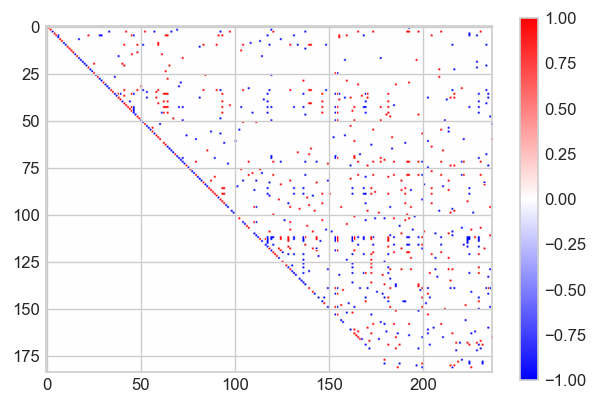

In [1662]:
import scipy.linalg as spla
P, L, U = spla.lu(A)
plt.figure(dpi=120)
plt.imshow(U, cmap='bwr')
plt.colorbar();

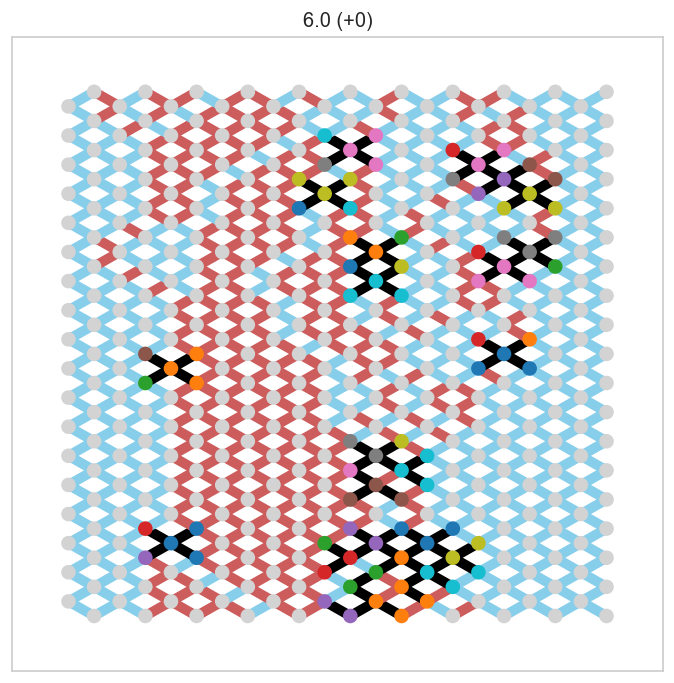

In [1316]:
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(7, 7))
paths = get_paths(constraints)
plot_cycle_basis(record, ax, which_colors='loops', paths=paths)

In [1317]:
print(constraints)

[(-1.0, [(1.0, ((17, 8), (18, 8))), (1.0, ((18, 8), (17, 9)))]), (0.0, [(-1.0, ((19, 9), (18, 8))), (1.0, ((18, 8), (17, 9)))]), (0.0, [(-1.0, ((19, 9), (18, 8))), (1.0, ((18, 8), (17, 9)))]), (1.0, [(-1.0, ((19, 9), (18, 8))), (-1.0, ((18, 8), (19, 8)))]), (0.0, [(-1.0, ((19, 9), (18, 8))), (1.0, ((18, 8), (17, 9)))]), (0.0, [(-1.0, ((19, 9), (18, 8))), (1.0, ((18, 8), (17, 9)))]), (-1.0, [(1.0, ((23, 8), (24, 8))), (1.0, ((24, 8), (23, 9)))]), (-1.0, [(1.0, ((26, 8), (25, 9))), (1.0, ((25, 9), (26, 9)))]), (1.0, [(-1.0, ((28, 9), (29, 9))), (-1.0, ((29, 9), (28, 8)))]), (0.0, [(1.0, ((10, 6), (9, 7))), (-1.0, ((11, 7), (10, 6)))]), (-1.0, [(1.0, ((6, 6), (5, 7))), (1.0, ((5, 7), (6, 7)))]), (0.0, [(1.0, ((1, 6), (0, 6))), (-1.0, ((1, 7), (2, 6)))]), (0.0, [(-1.0, ((3, 6), (2, 5))), (1.0, ((2, 5), (1, 6)))]), (0.0, [(1.0, ((3, 5), (4, 5))), (-1.0, ((3, 6), (2, 5)))]), (-1.0, [(1.0, ((6, 5), (5, 6))), (1.0, ((5, 6), (6, 6)))]), (1.0, [(-1.0, ((8, 6), (9, 6))), (-1.0, ((9, 6), (8, 5)))]

In [1280]:
variables = [tuple(x) for x in list(variables)]
for i in range(len(variables)):
    for j in range(len(variables)):
        if (variables[i] == variables[j][::-1] and i!=j):
            raise Exception


In [1281]:
print(variables)

SyntaxError: invalid syntax (3880395102.py, line 40)

# Brightness

In [61]:
# make brightness dataset
brightnesses = {}
for key, x in collated.items():
    brightnesses[key] = np.mean(np.mean(x, axis=3), axis=3)
    
for key, x in brightnesses.items():
    print(key, x.shape)

10 (9, 10000, 2)
12 (9, 10000, 2)
14 (9, 10000, 2)
16 (9, 10000, 2)
18 (9, 10000, 2)


In [62]:
key = str(10) #key, data/label, 

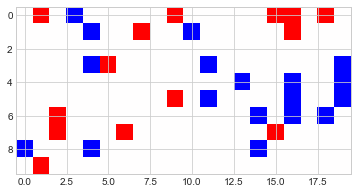

In [63]:
plt.imshow(collated[key][3, 0, 0], cmap='bwr', vmin=-1, vmax=1);

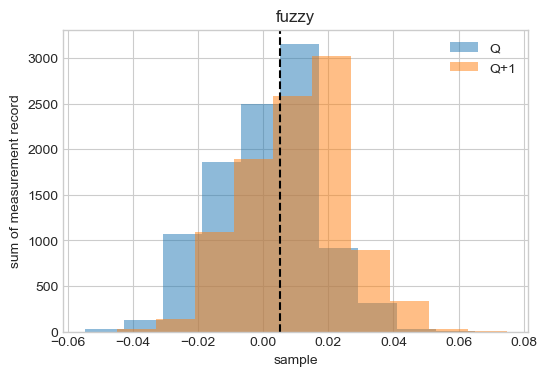

In [64]:
plt.figure(dpi=100)
plt.hist(brightnesses[key][0][:, 0], alpha=0.5, label='Q')
plt.hist(brightnesses[key][0][:, 1], alpha=0.5, label='Q+1')
plt.axvline(np.mean(brightnesses[key][0]), linestyle='--', c='black')

plt.title('fuzzy')
plt.ylabel('sum of measurement record')
plt.legend()
plt.xlabel('sample');

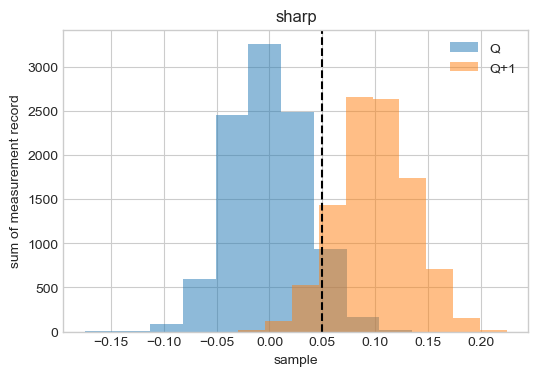

In [65]:
plt.figure(dpi=100)
plt.hist(brightnesses[key][-1][:, 0], alpha=0.5, label='Q')
plt.hist(brightnesses[key][-1][:, 1], alpha=0.5, label='Q+1')
plt.axvline(np.mean(brightnesses[key][-1]), linestyle='--', c='black')

plt.title('sharp')
plt.ylabel('sum of measurement record')
plt.legend()
plt.xlabel('sample');

In [67]:
#brightnesses[key] = ((np.mean(fuzzy_data_arr), fuzzy_brightness), (np.mean(sharp_data_arr), sharp_brightness))
accuracies = []
for key in brightnesses.keys():
    print(key, brightnesses[key].shape)
    acc = []
    for sharp_brightness in brightnesses[key]:
        x = sharp_brightness<np.mean(sharp_brightness)
        print(L, p)
        print('sharp Q   samples below the mean (true Q positives)   : ',  stp:=np.mean(x[:, 0])  )
        print('sharp Q+1 samples above the mean (true Q+1 positives) : ',  stn:=1-np.mean(x[:, 1]))
        print('---')
        print('sharp Q+1 samples below the mean (false Q positives)  : ',  sfp:=np.mean(x[:, 1])  )
        print('sharp Q   samples above the mean (false Q+1 positives): ',  sfn:=1-np.mean(x[:, 0]))
        print('---')
        print("sharp accuracy: ", sa:=(stp+stn)/(stp+stn+sfp+sfn))
        print('===')
        acc.append([sa])
    accuracies.append(acc)
accuracies = np.array(accuracies)[:, :, 0]

10 (9, 10000, 2)
18 0.5
sharp Q   samples below the mean (true Q positives)   :  0.685
sharp Q+1 samples above the mean (true Q+1 positives) :  0.5665
---
sharp Q+1 samples below the mean (false Q positives)  :  0.4335
sharp Q   samples above the mean (false Q+1 positives):  0.31499999999999995
---
sharp accuracy:  0.62575
===
18 0.5
sharp Q   samples below the mean (true Q positives)   :  0.6509
sharp Q+1 samples above the mean (true Q+1 positives) :  0.6627000000000001
---
sharp Q+1 samples below the mean (false Q positives)  :  0.3373
sharp Q   samples above the mean (false Q+1 positives):  0.34909999999999997
---
sharp accuracy:  0.6568
===
18 0.5
sharp Q   samples below the mean (true Q positives)   :  0.7244
sharp Q+1 samples above the mean (true Q+1 positives) :  0.6368
---
sharp Q+1 samples below the mean (false Q positives)  :  0.3632
sharp Q   samples above the mean (false Q+1 positives):  0.27559999999999996
---
sharp accuracy:  0.6806000000000001
===
18 0.5
sharp Q   sample

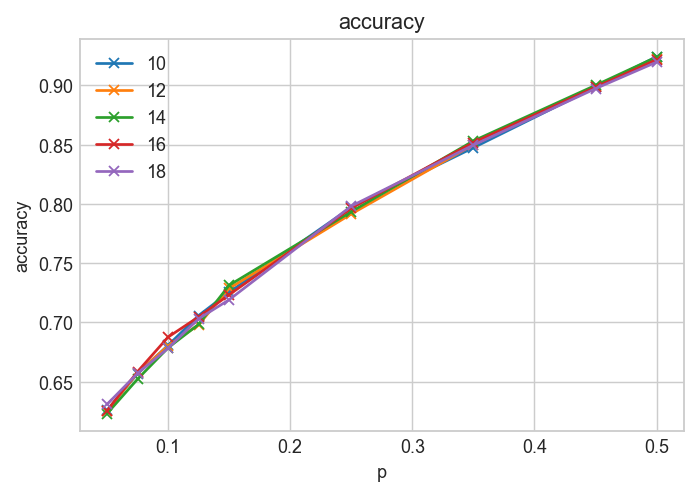

In [68]:
plt.figure(dpi=130)
plt.plot(ps, accuracies.T, label=Ls, marker='x')
plt.title('accuracy')
plt.xlabel('p')
plt.ylabel('accuracy')
plt.legend()

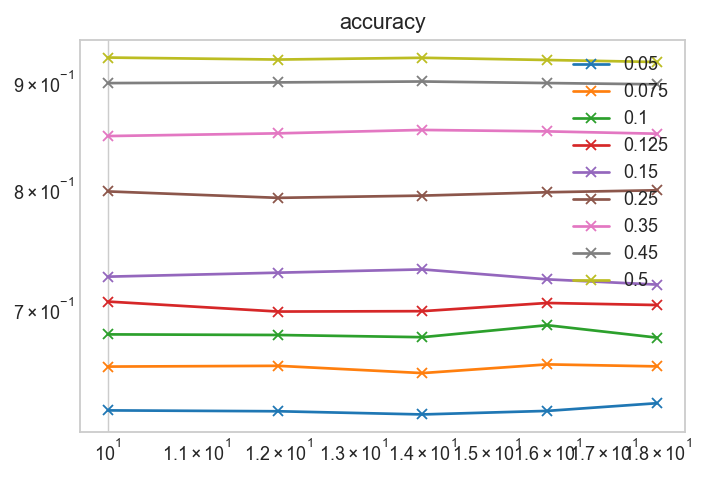

In [69]:
plt.figure(dpi=130)
plt.plot(Ls, accuracies, label=ps, marker='x')
plt.xscale('log')
plt.yscale('log')
plt.title('accuracy')
plt.legend()

In [70]:
(np.log(0.8)-np.log(0.7))/(np.log(18)-np.log(10))

0.22717662818491996

## Exploration/preprocessing

We need to do something so that the fuzzy and sharp data looks the same. As it stands, we're doing nothing.

In [37]:
def mask_arrs(arr, p, min_p):
    masked_arrs = []
    del_prob = 1-min_p/p
    masking_arr = np.random.choice([0, 1], size=arr.shape, p=[del_prob, 1-del_prob])
    masked_arr = masking_arr*arr
    return np.array(masked_arr)

def resize(arrs):
    """
    Resize arrays, such that they have the same total 1/-1s
    """
    pass


In [26]:
print(np.sum(np.abs(sharp_data)))
print(np.sum(np.abs(fuzzy_data)))

masked_sharp_data = mask_arrs(sharp_data, 0.5, 0.05)

print(np.sum(np.abs(masked_sharp_data)))

4000836
401003
400433


## Sharp training

### MLP

In [120]:
sharp_mlp = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(128, activation='relu'),
                                  tf.keras.layers.Dense(10, activation='softmax')])

sharp_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [121]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=5)
mlp_hist = sharp_mlp.fit(sharp_x_train, sharp_y_train, validation_data=(sharp_x_val, sharp_y_val), epochs=20, callbacks=[callbacks])

Epoch 1/20
 27/282 [=>............................] - ETA: 1s - loss: 1.6857 - accuracy: 0.4410   

2022-02-23 15:00:16.641558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


277/282 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8951

2022-02-23 15:00:17.820781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 2s 7ms/step - loss: 0.3258 - accuracy: 0.8967 - val_loss: 0.1014 - val_accuracy: 0.9637
Epoch 2/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0691 - accuracy: 0.9786 - val_loss: 0.0992 - val_accuracy: 0.9635
Epoch 3/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0991 - val_accuracy: 0.9649
Epoch 4/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0207 - accuracy: 0.9961 - val_loss: 0.1019 - val_accuracy: 0.9655
Epoch 5/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.1026 - val_accuracy: 0.9655
Epoch 6/20
282/282 [==============================] - 2s 6ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.1045 - val_accuracy: 0.9669
Epoch 7/20
282/282 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 0.9675
Epoch 8/20
282/28

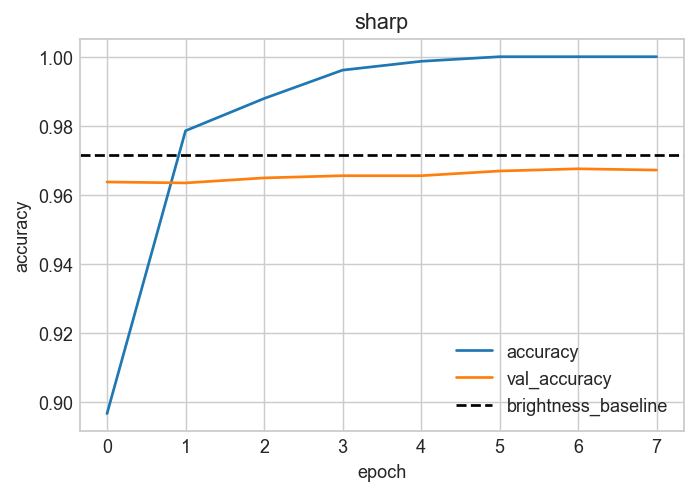

In [ ]:
plt.figure(dpi=130)
plt.plot(mlp_hist.history['accuracy'], label='accuracy')
plt.plot(mlp_hist.history['val_accuracy'], label='val_accuracy')
plt.axhline(sa, linestyle='--', c='black', label='brightness_baseline')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("sharp")
plt.legend()

### ConvNet

In [155]:
input_shape = sharp_x_train.shape[1:]

sharp_convnet = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", padding="SAME"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu", padding="SAME"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)


sharp_convnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [156]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=5)
cnn_hist = sharp_convnet.fit(sharp_x_train, sharp_y_train, validation_data=(sharp_x_val, sharp_y_val), epochs=20, callbacks=[callbacks])

Epoch 1/20
  5/282 [..............................] - ETA: 3s - loss: 0.7186 - accuracy: 0.5063 

2022-02-23 15:01:51.554330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


281/282 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8288

2022-02-23 15:01:53.571588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 3s 11ms/step - loss: 0.3691 - accuracy: 0.8288 - val_loss: 0.1717 - val_accuracy: 0.9427
Epoch 2/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1632 - accuracy: 0.9382 - val_loss: 0.1900 - val_accuracy: 0.9221
Epoch 3/20
282/282 [==============================] - 2s 9ms/step - loss: 0.1277 - accuracy: 0.9517 - val_loss: 0.1555 - val_accuracy: 0.9383
Epoch 4/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1166 - accuracy: 0.9540 - val_loss: 0.1276 - val_accuracy: 0.9515
Epoch 5/20
282/282 [==============================] - 3s 11ms/step - loss: 0.1016 - accuracy: 0.9607 - val_loss: 0.0858 - val_accuracy: 0.9684
Epoch 6/20
282/282 [==============================] - 3s 11ms/step - loss: 0.0854 - accuracy: 0.9689 - val_loss: 0.0790 - val_accuracy: 0.9690
Epoch 7/20
282/282 [==============================] - 3s 12ms/step - loss: 0.0924 - accuracy: 0.9673 - val_loss: 0.0709 - val_accuracy: 0.9737
Epoch 8/20
28

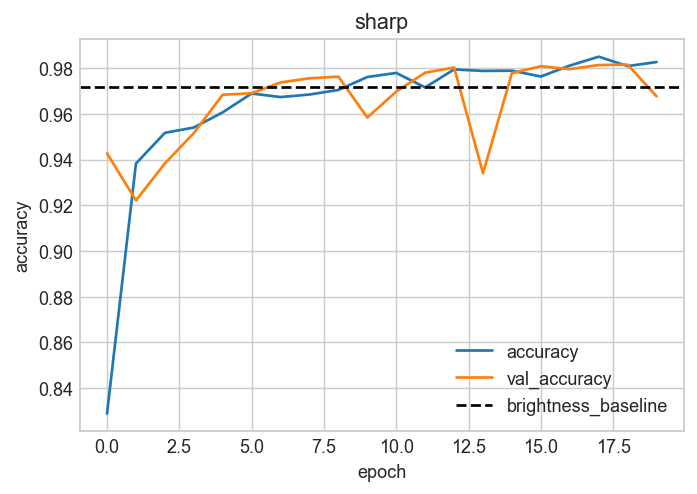

In [157]:
plt.figure(dpi=130)
plt.plot(cnn_hist.history['accuracy'], label='accuracy')
plt.plot(cnn_hist.history['val_accuracy'], label='val_accuracy')
plt.axhline(sa, linestyle='--', c='black', label='brightness_baseline')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("sharp")
plt.legend()

## Masked sharp training

In [32]:
masked_sharp_x_train = np.concatenate([masked_sharp_data[:, i, :, :] for i in [0, 1]], axis=0)
masked_sharp_y_train = np.concatenate([np.zeros((10000, 1)), np.ones((10000, 1))], axis=0)

perm = np.arange(len(masked_sharp_x_train))
np.random.shuffle(perm)

masked_sharp_x_train = masked_sharp_x_train[perm]
masked_sharp_y_train = masked_sharp_y_train[perm]

masked_sharp_x_val, masked_sharp_x_train = masked_sharp_x_train[9000:], masked_sharp_x_train[:9000]
masked_sharp_y_val, masked_sharp_y_train = masked_sharp_y_train[9000:], masked_sharp_y_train[:9000]

In [33]:
masked_sharp_mlp = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(128, activation='relu'),
                                  tf.keras.layers.Dense(10, activation='softmax')])

masked_sharp_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
hist = masked_sharp_mlp.fit(masked_sharp_x_train, masked_sharp_y_train, validation_data=(masked_sharp_x_val, masked_sharp_y_val), epochs=5)

Epoch 1/5
 26/282 [=>............................] - ETA: 1s - loss: 1.9772 - accuracy: 0.4183

2022-02-22 15:33:01.687810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


279/282 [============================>.] - ETA: 0s - loss: 0.9144 - accuracy: 0.5883

2022-02-22 15:33:02.903300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 2s 7ms/step - loss: 0.9120 - accuracy: 0.5891 - val_loss: 0.6411 - val_accuracy: 0.6505
Epoch 2/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5922 - accuracy: 0.6884 - val_loss: 0.6314 - val_accuracy: 0.6505
Epoch 3/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5524 - accuracy: 0.7214 - val_loss: 0.6359 - val_accuracy: 0.6516
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5093 - accuracy: 0.7550 - val_loss: 0.6484 - val_accuracy: 0.6461
Epoch 5/5
282/282 [==============================] - 2s 7ms/step - loss: 0.4518 - accuracy: 0.8002 - val_loss: 0.6704 - val_accuracy: 0.6390


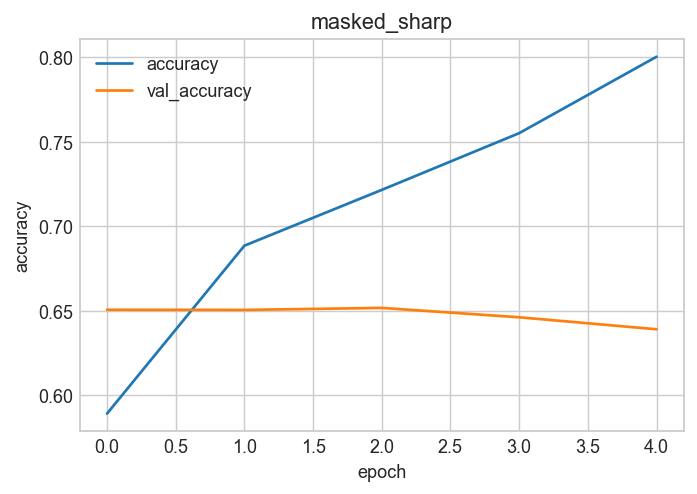

In [35]:
plt.figure(dpi=130)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("masked_sharp")
plt.legend()

## Fuzzy training

In [37]:
fuzzy_mlp = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(128, activation='relu'),
                                  tf.keras.layers.Dense(10, activation='softmax')])

fuzzy_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
hist = fuzzy_mlp.fit(fuzzy_x_train, fuzzy_y_train, validation_data=(fuzzy_x_val, fuzzy_y_val), epochs=5)

Epoch 1/5
 28/282 [=>............................] - ETA: 0s - loss: 1.9453 - accuracy: 0.4118

2022-02-22 15:33:18.443520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 0.9073 - accuracy: 0.5920

2022-02-22 15:33:19.603287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 2s 7ms/step - loss: 0.9073 - accuracy: 0.5920 - val_loss: 0.6391 - val_accuracy: 0.6511
Epoch 2/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5893 - accuracy: 0.6943 - val_loss: 0.6310 - val_accuracy: 0.6518
Epoch 3/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5466 - accuracy: 0.7228 - val_loss: 0.6375 - val_accuracy: 0.6524
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5025 - accuracy: 0.7588 - val_loss: 0.6514 - val_accuracy: 0.6460
Epoch 5/5
282/282 [==============================] - 2s 7ms/step - loss: 0.4454 - accuracy: 0.8071 - val_loss: 0.6635 - val_accuracy: 0.6491


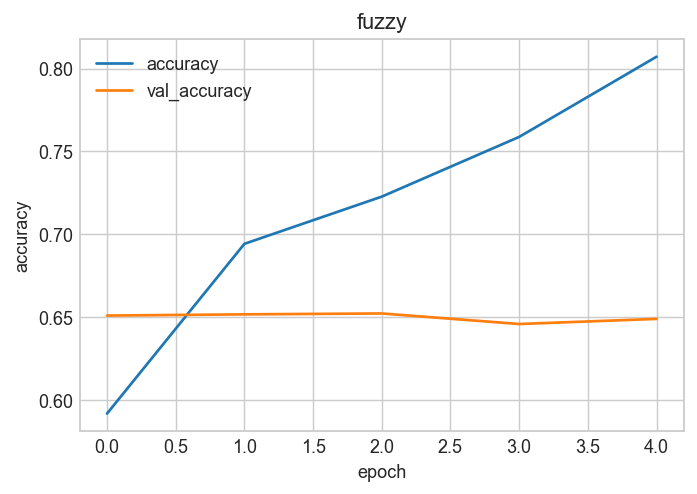

In [39]:
plt.figure(dpi=130)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("fuzzy")
plt.legend()

## Testing

In [40]:
fuzzy_mlp.evaluate(fuzzy_x_val, fuzzy_y_val)

344/344 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.6491


[0.663496732711792, 0.6490909457206726]

In [41]:
fuzzy_mlp.evaluate(sharp_x_val, sharp_y_val)

344/344 [==============================] - 1s 3ms/step - loss: 0.5468 - accuracy: 0.8036


[0.5468347668647766, 0.8036364316940308]

In [42]:
sharp_mlp.evaluate(sharp_x_val, sharp_y_val)

 50/344 [===>..........................] - ETA: 0s - loss: 2.5624 - accuracy: 0.1069

2022-02-22 15:33:33.856689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


344/344 [==============================] - 1s 3ms/step - loss: 2.5490 - accuracy: 0.1163


[2.548950433731079, 0.11627273261547089]

In [43]:
sharp_mlp.evaluate(fuzzy_x_val, fuzzy_y_val)

344/344 [==============================] - 1s 3ms/step - loss: 2.3225 - accuracy: 0.1209


[2.3224570751190186, 0.12090909481048584]

In [44]:
sharp_convnet.evaluate(fuzzy_x_val, fuzzy_y_val)

344/344 [==============================] - 1s 4ms/step - loss: 1.1309 - accuracy: 0.6419


[1.1308553218841553, 0.641909122467041]

In [129]:
# from https://github.com/ussserrr/percolation-python
def generate_grid(grid_y_dimension, grid_x_dimension, probability_of_zero):
    """
    Generate grid (grid_y_dimension X grid_x_dimension) (vertical X horizontal)
    and fill it with ones and zeros in accordance with the given probability of
    zero. Also, we add borders of zeros to handle operations at edges (i.e.
    where (x-1)-like expressions could be met). For example, for 5x5 grid we
    will get:
        array([[0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 1., 1., 1., 1., 0.],
               [0., 1., 0., 0., 0., 1., 0.],
               [0., 1., 1., 0., 0., 0., 0.],
               [0., 1., 1., 0., 1., 0., 0.],
               [0., 1., 1., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0.]])
    returns:
        numpy.array
    """

    # form the grid (with borders of zeros)
    grid = np.zeros((grid_y_dimension+2,grid_x_dimension+2))

    # fill the grid
    for cell in np.nditer(grid[1:-1, 1:-1], op_flags=['readwrite']):
        cell[...] = 0 if np.random.random()<probability_of_zero else 1

    return grid



def find_clusters(grid):
    """
    Find individual clusters (i.e. neighboring occupied cells) by iterating
    through the grid and reassigning cells' labels accordingly to their
    belonging to the same (or not) cluster
    returns:
        ids: final np.array of IDs
    """

    num_of_ones = np.count_nonzero(grid)

    # 1-D array of labels (IDs) of each occupied cell. At the beginning,
    # all labels are different and are simply counted like 0,1,2,3,...
    ids = np.arange(grid.size)
    # 2-D array that storing (y,x) coordinates of occupied cells
    coords = [list(x) for x in np.argwhere(grid>0)]
    # We operate with these two arrays in the parallel way so both ID and
    # coordinates are always match to each other, e.g.:
    #
    #   id   y x
    #    0  [2,0]
    #    1  [2,3]
    #    2  [4,5]
    #      ...
    #

    # Reassign IDs (starting from the upper left corner) until there are no
    # more left so called wrong labels - 'cw'. We change a label according to
    # IDs of two closest neighboring cells (up and left ones)
    while True:
        cw = []

        for i in np.arange(ids.size):
            # extract coordinates of an i-th current cell
            y,x = coords[i]

            # If only one neighbor is occupied, we change a label of the
            # current cell to the label of that neighbor. First, we need to
            # find ID of this neighbor by its known coordinates
            if grid[y-1][x-1]==1 and grid[y][x-1]==0:
                ids[i] = ids[coords.index([y-1,x])]
            elif grid[y][x-1]==1 and grid[y-1][x]==0:
                ids[i] = ids[coords.index([y,x-1])]

            # if both neighbors are occupied then we assign a smaller label
            elif grid[y-1][x]==1 and grid[y][x-1]==1:
                first_neighbor_id = ids[coords.index([y-1,x])]
                second_neighbor_id = ids[coords.index([y,x-1])]
                ids[i] = np.min([first_neighbor_id, second_neighbor_id])

                # if IDs are unequal then we store them to correct later
                if first_neighbor_id!=second_neighbor_id:
                    cw.append([first_neighbor_id,second_neighbor_id])

        # quit the loop if there are no more wrong labels
        if cw==[]:
            break
        # else correct labels
        else:
            for id1,id2 in cw:
                wrong_id = np.max([id1,id2])
                correct_id = np.min([id1,id2])
                ids[ids==wrong_id] = correct_id

    return coords,ids




def is_percolation(coords, ids, grid_y_dimension, grid_x_dimension):
    """
    Define whether there is a percolation in the given grid and what its type.
    Correctly works only if find_clusters() function were called before
    """

    # ids contains labels of all occupied cells so we need to find uniq IDs
    # (i.e. all remaining clusters), for example
    #
    #   ids = {0,0,0,0,1,2,2,0,0,3,3,3,5,5,2}  =>
    #   np.unique(ids) = {0,1,2,3,5}
    #
    # Then we store coordinates of cells of all these clusters like
    #
    #   clusters_coordinates = [ [[1,2],  [[3,4],
    #                             [2,2],   [3,5],
    #                             [2,3]],  [4,5]] ]
    #
    clusters_coordinates = []
    for idx in np.unique(ids):
        clusters_coordinates.append([
            coords[k] for k in range(len(ids)) if ids[k]==idx
        ])

    # search for percolated cluster(s)
    upwards = False
    lefttoright = False
    for cluster in clusters_coordinates:
        cluster = np.array(cluster).T
        if (1 in cluster[0]) and (grid_y_dimension in cluster[0]):
            upwards = True
        if (1 in cluster[1]) and (grid_x_dimension in cluster[1]):
            lefttoright = True

    if upwards and not lefttoright:
        return 'upwards'
    elif not upwards and lefttoright:
        return 'lefttoright'
    elif upwards and lefttoright:
        return 'both'
    else:
        return 0
    
import numpy as np

import matplotlib.pyplot as plt


# parameters
method = 'labels'  # 'labels' or 'graph'

#              y   x
grid_dims = [[10, 12],
             [15, 15]]

num_of_experiments = 100  # number of experiments for each probability

probability_step = 0.05


probability_of_zero_array = np.arange(probability_step, 1.0, probability_step)

for grid_y_dim,grid_x_dim in grid_dims:
    experiments_with_percolation_array = []

    for probability_of_zero in probability_of_zero_array:
        experiments_with_percolation = 0

        for experiment in range(num_of_experiments):
            grid = generate_grid(grid_y_dim, grid_x_dim, probability_of_zero)

            if method=='labels':
                coords,ids = find_clusters(grid)
                print(grid, grid_y_dim, grid_x_dim, grid.shape)
                raise Exception
                result = is_percolation(coords, ids, grid_y_dim, grid_x_dim)
            elif method=='graph':
                G = generate_graph(grid, grid_y_dim, grid_x_dim)
                clusters = find_clusters(grid, G)
                result = is_percolation(clusters, grid_y_dim, grid_x_dim)

            if result=='upwards' or result=='lefttoright' or result=='both':
                experiments_with_percolation += 1

        experiments_with_percolation_array.append(
            experiments_with_percolation/num_of_experiments)

        # display progress
        print('\r{}x{}: {:.2f}'.format(grid_x_dim, grid_y_dim, probability_of_zero), end='')
    print()

    plt.plot(probability_of_zero_array, experiments_with_percolation_array,
             label='{}x{}, N={}'\
             .format(grid_x_dim, grid_y_dim, num_of_experiments))


plt.legend()
plt.suptitle("Percolation threshold")
plt.xlabel("Probability of 0")
plt.ylabel("Percolation ratio")

plt.show()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 10 12 (12, 14)


Exception: 

In [139]:

print(grid)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.

In [135]:
grid = generate_grid(grid_y_dim, grid_x_dim, probability_of_zero)

In [141]:
print(result)

0


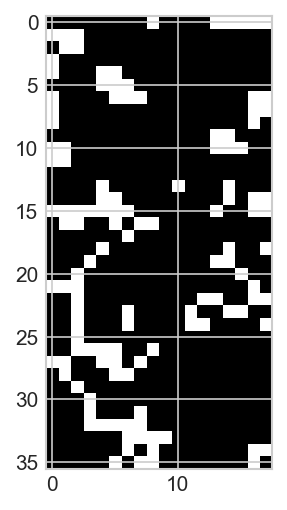

In [208]:
plt.figure(dpi=150)
plt.imshow(abs_record)

In [672]:
print(ids[0, 0], ids[-1, 0])

-1 -1
